In [463]:
# Bring in (new) PNC cohort

import pickle
from pathlib import Path
import numpy as np

newdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC'
newdemo = pickle.load(open(f'{newdir}/demographics.pkl', 'rb'))

newfc = []
age = []
sex = []
race = []

for sub in newdemo['age_at_cnb']:
    for task in ['rest', 'nback', 'emoid']:
        f = f'{newdir}/fc/{sub}_task-{task}_fc.npy'
        if not Path(f).exists():
            continue
        if sub not in newdemo['Race'] or newdemo['Race'][sub] not in ['AA', 'EA']:
            continue
        p = np.load(f)
        a = newdemo['age_at_cnb'][sub]
        s = newdemo['Sex'][sub] == 'M'
        r = newdemo['Race'][sub] == 'AA'
        newfc.append(p)
        age.append(a)
        sex.append(s)
        race.append(r)
        
newfc = np.stack(newfc)
age = np.array(age)
sex = np.array(sex)
race = np.array(race)

print(age.shape)
print(np.mean(age))
print(np.mean(sex))
print(np.mean(race))
print(newfc.shape)

(3849,)
14.398285268901013
0.473629514159522
0.4811639386853728
(3849, 34716)


In [470]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression

class LowRankReg(nn.Module):
    def __init__(self):
        super(LowRankReg, self).__init__()
        dim = 10
        self.A = nn.Parameter((264*dim)**-0.5*torch.randn(dim,264,1).float().cuda())
        self.b = nn.Parameter(torch.randn(dim).float().cuda())
        
    def get_w(self):
        a,b = torch.triu_indices(264, 264, offset=1)
        w = torch.einsum('dac,dbc->dab', self.A, self.A)
        return w[:,a,b]
    
    def get_hloss(self):
        w = self.get_w()
        prod_sum = 0
        for i in range(w.shape[0]):
            for j in range(i, w.shape[0]):
                prod_sum += torch.sum(torch.abs(w[i]*w[j]))
        return prod_sum
    
    def to_imgs(self):
        I = np.zeros((self.A.shape[0],264,264))
        w = self.get_w()
        w = w.detach().cpu().numpy()
        a,b = np.triu_indices(264, 1)
        I[:,a,b] = w
        I[:,b,a] = w
        return I
    
    def to_sum_img(self):
        return np.sum(self.to_imgs(), axis=0)
    
    def to_img(self, i):
        return self.to_imgs()[i]
    
    def forward(self, x):
        w = self.get_w()
        y = torch.einsum('aw,dw->a', x, w)
        return y
    
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def celoss(yhat, y):
    yhat = sigmoid(yhat)
    yhat = yhat - 1e-5*yhat/torch.abs(yhat)
    return -torch.sum(y*torch.log(yhat)+(1-y)*torch.log(1-yhat))/len(yhat)

idcs = np.random.permutation(newfc.shape[0])
# idcs = idcs[:2500]
x = newfc[idcs]
y = race[idcs]

min_loss = 0
sav = None

for _ in range(10):

    xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)

#     mu = np.mean(ytr)
#     ytr -= mu
#     yt -= mu
    
#     reg = Ridge(alpha=1).fit(xtr, ytr)
#     yhat = reg.predict(xt)
#     print(rmse(yhat, yt))

#     clf = LogisticRegression(C=100, max_iter=1000).fit(xtr, ytr)
#     yhat = clf.predict(xt)
#     print(np.mean(yhat == yt))
    
#     break

    xtr, xt, ytr, yt = [torch.from_numpy(a).float().cuda() for a in [xtr, xt, ytr, yt]]
    
    lrreg = LowRankReg()
    optim = torch.optim.Adam(lrreg.parameters(), lr=1e-3, weight_decay=1e-2)

    nepochs = 1000
    pperiod = 100

    for e in range(nepochs):
        optim.zero_grad()
        yhat = lrreg(xtr)
        loss = celoss(yhat, ytr)
#         sloss = 0.01*lrreg.get_hloss()
#         sloss = 0.01*torch.sum(torch.abs(lrreg.A))
        (loss).backward()
        optim.step()
        if e == nepochs-1 or e % pperiod == 0:
            print(f'{e} {float(loss)} {0*float(sloss)}')

    yhat = lrreg(xt)
    acc = np.mean(((sigmoid(yhat) > 0.5) == yt).detach().cpu().numpy())
#     null = rmseloss(0, yt)
    print(f'Test: {float(acc)}')
    print('---')
    
    if acc > min_loss:
        print('Saving')
        min_loss = float(acc)
        sav = lrreg

0 0.6903054714202881 0.0
100 0.30057570338249207 0.0
200 0.17279469966888428 0.0
300 0.13778576254844666 0.0
400 0.1253862828016281 0.0
500 0.11950045824050903 0.0
600 0.11619727313518524 0.0
700 0.11407609283924103 0.0
800 0.11266417801380157 0.0
900 0.11237483471632004 0.0
999 0.11096128821372986 0.0
Test: 0.8974025974025974
---
Saving
0 0.6936795115470886 0.0
100 0.33186954259872437 0.0
200 0.18120914697647095 0.0
300 0.1413383036851883 0.0
400 0.12610071897506714 0.0
500 0.11963911354541779 0.0
600 0.1160813570022583 0.0
700 0.11390984803438187 0.0
800 0.11237464100122452 0.0
900 0.11130774021148682 0.0
999 0.11055058985948563 0.0
Test: 0.9064935064935065
---
Saving
0 0.6892839074134827 0.0
100 0.30602043867111206 0.0
200 0.1694592833518982 0.0
300 0.13523730635643005 0.0
400 0.12314987182617188 0.0
500 0.11729785054922104 0.0
600 0.11412595212459564 0.0
700 0.11215529590845108 0.0
800 0.11089884489774704 0.0
900 0.11000420153141022 0.0
999 0.10938026756048203 0.0
Test: 0.897402597

KeyboardInterrupt: 

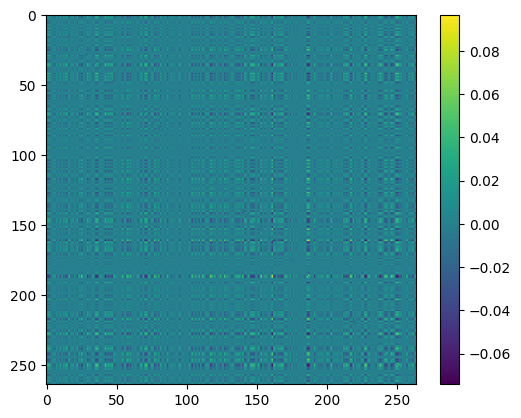

In [480]:
import matplotlib.pyplot as plt

# plt.imshow(remap(vec2mat(reg.coef_)))
# plt.imshow(remap(vec2mat(clf.coef_)))
# plt.imshow(remap(sav.to_sum_img()))
plt.imshow(remap(sav.to_img(0)))
plt.colorbar()
plt.show()

In [243]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
